# Introduction

In this lab, we will learn how to use approximate nearest neighbors in TSNE using Python's scikit-learn library.

# Install Required Packages

We need to install the **nmslib** and **pynndescent** packages. These packages can be installed using pip command.

In [ ]:
!pip install nmslib pynndescent

# Import Required Libraries

We need to import the required libraries, including nmslib, pynndescent, sklearn, numpy, scipy, and matplotlib.

In [16]:
import sys
import joblib
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsTransformer
from sklearn.pipeline import make_pipeline
from pynndescent import PyNNDescentTransformer
from matplotlib.ticker import NullFormatter
# import nmslib
import hnswlib
import time

# Define a Wrapper Class for nmslib

We define a wrapper class for nmslib to implement the scikit-learn API to the nmslib, as well as a loading function. The NMSlibTransformer class takes n_neighbors, metric, method, and n_jobs as parameters. The fit() method initializes the nmslib and adds the data points to it. The transform() method finds the nearest neighbors and returns a sparse matrix.

In [11]:
class HNSWlibTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, n_neighbors=5, metric="euclidean", ef=200):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.ef = ef

    def fit(self, X):
        metric_map = {
            "euclidean": "l2",
            "cosine": "cosine",
            "ip": "ip"
        }
        if self.metric not in metric_map:
            raise ValueError(f"Unsupported metric '{self.metric}' for hnswlib. Use one of {list(metric_map.keys())}.")

        self._dim = X.shape[1]
        self._index = hnswlib.Index(space=metric_map[self.metric], dim=self._dim)
        self._index.init_index(max_elements=X.shape[0], ef_construction=200, M=16)
        self._index.add_items(X)
        self._index.set_ef(self.ef)
        self._X_fit_shape = X.shape
        return self

    def transform(self, X):
        indices, distances = self._index.knn_query(X, k=self.n_neighbors + 1)
        n_samples = X.shape[0]
        indptr = np.arange(0, n_samples * (self.n_neighbors + 1) + 1, self.n_neighbors + 1)
        return csr_matrix(
            (distances.ravel(), indices.ravel(), indptr),
            shape=(n_samples, self._X_fit_shape[0]),
        )


# Define a Function to Load MNIST Dataset

We define a function load_mnist() to load the MNIST dataset, shuffle the data, and return only the specified number of samples.

In [12]:
def load_mnist(n_samples):
    """Load MNIST, shuffle the data, and return only n_samples."""
    mnist = fetch_openml("mnist_784", as_frame=False, parser="pandas")
    X, y = shuffle(mnist.data, mnist.target, random_state=2)
    return X[:n_samples] / 255, y[:n_samples]

# Benchmark Different Nearest Neighbors Transformers

We benchmark the different exact/approximate nearest neighbors transformers. We define the datasets, transformers, and parameters, including n_iter, perplexity, metric, and n_neighbors. We measure the time it takes to fit and transform each transformer on each dataset. We print out the time it took to fit and transform each transformer.

In [13]:
datasets = [
    ("MNIST_10000", load_mnist(n_samples=10_000)),
    ("MNIST_20000", load_mnist(n_samples=20_000)),
]

n_iter = 500
perplexity = 30
metric = "euclidean"
n_neighbors = int(3.0 * perplexity + 1) + 1

tsne_params = dict(
    init="random",  # pca not supported for sparse matrices
    perplexity=perplexity,
    method="barnes_hut",
    random_state=42,
    n_iter=n_iter,
    learning_rate="auto",
)

transformers = [
    (
        "KNeighborsTransformer",
        KNeighborsTransformer(n_neighbors=n_neighbors, mode="distance", metric=metric),
    ),
    (
        "HNSWlibTransformer",
        HNSWlibTransformer(n_neighbors=n_neighbors, metric=metric),
    ),
    (
        "PyNNDescentTransformer",
        PyNNDescentTransformer(
            n_neighbors=n_neighbors, metric=metric, parallel_batch_queries=True
        ),
    ),
]


for dataset_name, (X, y) in datasets:
    msg = f"Benchmarking on {dataset_name}:"
    print(f"\n{msg}\n" + str("-" * len(msg)))

    for transformer_name, transformer in transformers:
        longest = np.max([len(name) for name, model in transformers])
        start = time.time()
        transformer.fit(X)
        fit_duration = time.time() - start
        print(f"{transformer_name:<{longest}} {fit_duration:.3f} sec (fit)")
        start = time.time()
        Xt = transformer.transform(X)
        transform_duration = time.time() - start
        print(f"{transformer_name:<{longest}} {transform_duration:.3f} sec (transform)")
        if transformer_name == "PyNNDescentTransformer":
            start = time.time()
            Xt = transformer.transform(X)
            transform_duration = time.time() - start
            print(
                f"{transformer_name:<{longest}} {transform_duration:.3f} sec"
                " (transform)"
            )


Benchmarking on MNIST_10000:
----------------------------
KNeighborsTransformer  0.011 sec (fit)
KNeighborsTransformer  0.461 sec (transform)
HNSWlibTransformer     1.572 sec (fit)
HNSWlibTransformer     1.275 sec (transform)
PyNNDescentTransformer 7.443 sec (fit)
PyNNDescentTransformer 4.434 sec (transform)
PyNNDescentTransformer 0.454 sec (transform)

Benchmarking on MNIST_20000:
----------------------------
KNeighborsTransformer  0.036 sec (fit)
KNeighborsTransformer  1.672 sec (transform)
HNSWlibTransformer     3.506 sec (fit)
HNSWlibTransformer     2.842 sec (transform)
PyNNDescentTransformer 5.604 sec (fit)
PyNNDescentTransformer 3.597 sec (transform)
PyNNDescentTransformer 1.283 sec (transform)


# Visualize TSNE Embedding

We visualize the TSNE embeddings using different nearest neighbors transformers. We define transformers as a list containing three pipelines: TSNE with internal NearestNeighbors, TSNE with KNeighborsTransformer, and TSNE with NMSlibTransformer. We iterate over the datasets and transformers and plot the TSNE embeddings, which should be similar across methods. We show the plot at the end.


Benchmarking on MNIST_10000:
----------------------------


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


TSNE with internal NearestNeighbors 9.724 sec (fit_transform)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


TSNE with KNeighborsTransformer     9.940 sec (fit_transform)
TSNE with HNSWlibTransformer        12.001 sec (fit_transform)

Benchmarking on MNIST_20000:
----------------------------
TSNE with internal NearestNeighbors 20.910 sec (fit_transform)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


TSNE with KNeighborsTransformer     21.191 sec (fit_transform)
TSNE with HNSWlibTransformer        25.448 sec (fit_transform)


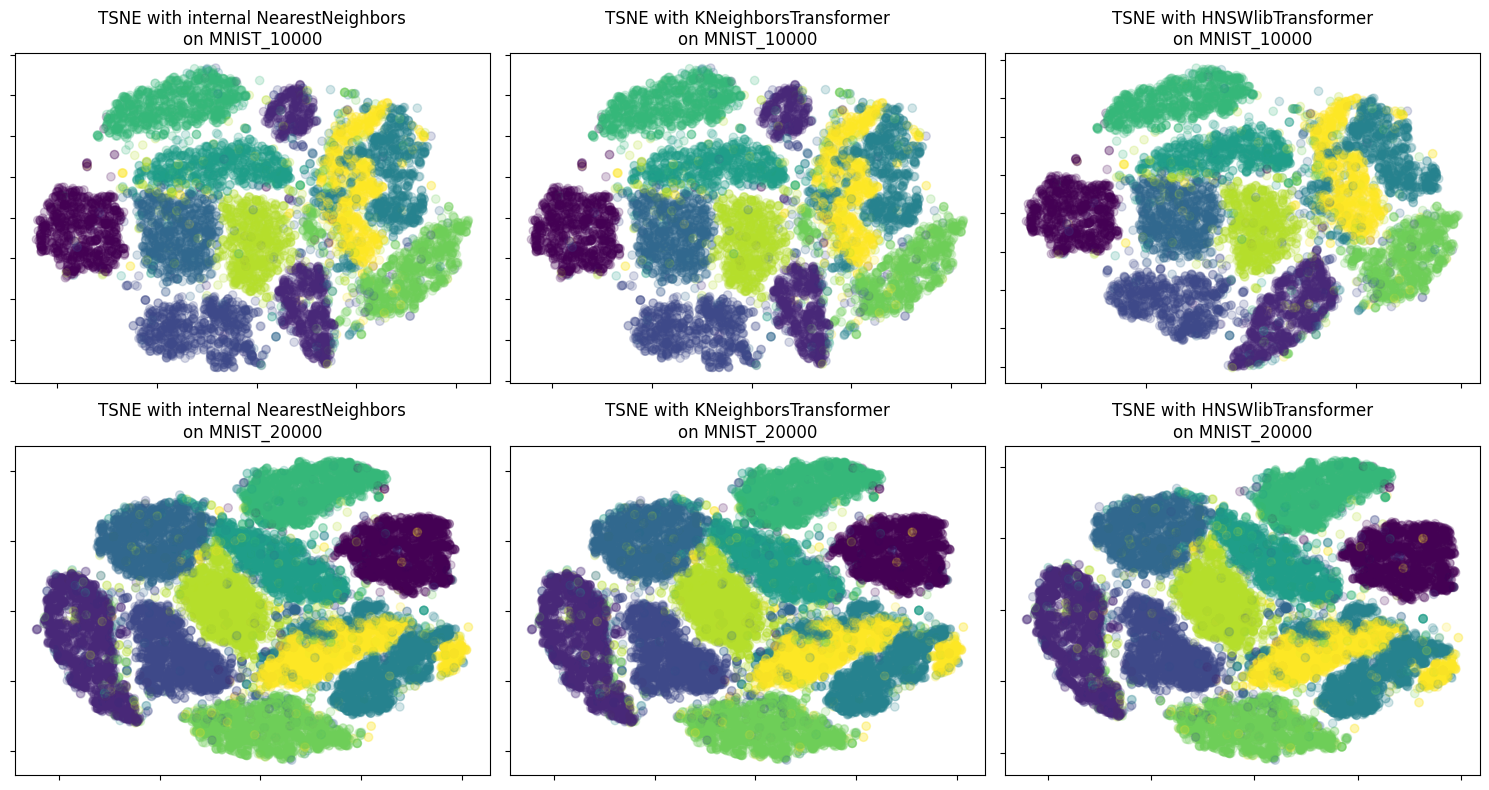

In [17]:
transformers = [
    ("TSNE with internal NearestNeighbors", TSNE(metric=metric, **tsne_params)),
    (
        "TSNE with KNeighborsTransformer",
        make_pipeline(
            KNeighborsTransformer(
                n_neighbors=n_neighbors, mode="distance", metric=metric
            ),
            TSNE(metric="precomputed", **tsne_params),
        ),
    ),
    (
        "TSNE with HNSWlibTransformer",
        make_pipeline(
            HNSWlibTransformer(n_neighbors=n_neighbors, metric=metric),
            TSNE(metric="precomputed", **tsne_params),
        ),
    ),
]

nrows = len(datasets)
ncols = np.sum([1 for name, model in transformers if "TSNE" in name])
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, squeeze=False, figsize=(5 * ncols, 4 * nrows)
)
axes = axes.ravel()
i_ax = 0

for dataset_name, (X, y) in datasets:
    msg = f"Benchmarking on {dataset_name}:"
    print(f"\n{msg}\n" + str("-" * len(msg)))

    for transformer_name, transformer in transformers:
        longest = np.max([len(name) for name, model in transformers])
        start = time.time()
        Xt = transformer.fit_transform(X)
        transform_duration = time.time() - start
        print(
            f"{transformer_name:<{longest}} {transform_duration:.3f} sec"
            " (fit_transform)"
        )

        # plot TSNE embedding which should be very similar across methods
        axes[i_ax].set_title(transformer_name + "\non " + dataset_name)
        axes[i_ax].scatter(
            Xt[:, 0],
            Xt[:, 1],
            c=y.astype(np.int32),
            alpha=0.2,
            cmap=plt.cm.viridis,
        )
        axes[i_ax].xaxis.set_major_formatter(NullFormatter())
        axes[i_ax].yaxis.set_major_formatter(NullFormatter())
        axes[i_ax].axis("tight")
        i_ax += 1

fig.tight_layout()
plt.show()

# Summary

In this lab, we learned how to use approximate nearest neighbors in TSNE using Python's scikit-learn library. We imported the required libraries, defined a wrapper class for nmslib, defined a function to load the MNIST dataset, benchmarked different nearest neighbors transformers, and visualized TSNE embeddings. We learned that the default TSNE estimator with its internal NearestNeighbors implementation is roughly equivalent to the pipeline with TSNE and KNeighborsTransformer in terms of performance. We also learned that the approximate NMSlibTransformer is already slightly faster than the exact search on the smallest dataset but this speed difference is expected to become more significant on datasets with a larger number of samples.